# Simulated Real-time Flow of Prediction

cuda
lenSignal:443904
Plotting: ../Dataset_Emotiv_mat/eeg_record17.mat


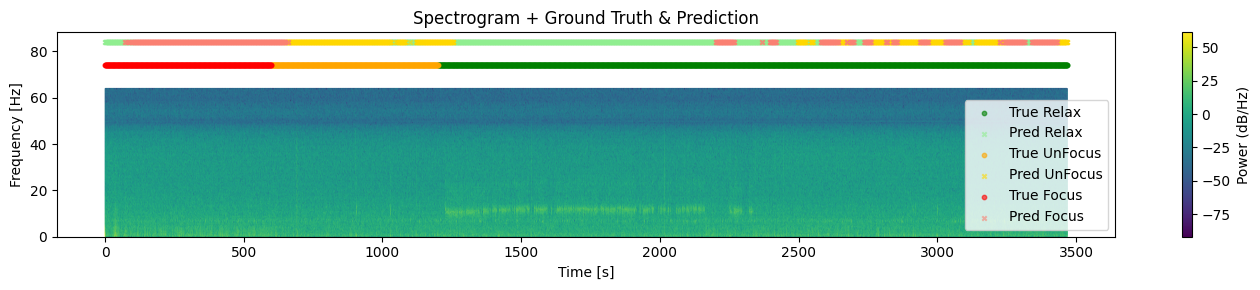

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

import os
from signal_processing import DCBlockingFilter, WindowIIRNotchFilter, WindowButterBandpassFilter, WindowFilter
from features import extract_welch_features

import torch
import numpy as np
import pandas as pd
from model import MC_Model_1D 
import scipy.io


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


label_map = {0: 'Relax', 1: 'Unfocus', 2: 'Focus'}
color_map = {0: 'green', 1: 'blue', 2: 'red'}

fs = 128
test_state = 0

hop = fs*1

frame_size = 64
window_size = 8*fs


def create_filter_chain(fs):
    return WindowFilter([
        DCBlockingFilter(alpha=0.99),
        # WindowIIRNotchFilter(60, 12, fs),
        # WindowIIRNotchFilter(50, 5, fs),
    ])



file = '../Dataset_Emotiv_mat/eeg_record17.mat'
mkpt1 = int(fs*10*60)
mkpt2 = int(fs*20*60)
mkpt3 = int(fs*30*60)

mat_data = scipy.io.loadmat(file)
eeg_data = mat_data['o']['data'][0][0][:, 3:18]

channel_names = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
    'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'state'
]

Selected_Channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8']

df = pd.DataFrame(eeg_data, columns=channel_names)
df['state'] = df['state'].astype(str)
df.loc[:mkpt1, 'state'] = 'Focus'
df.loc[mkpt1:mkpt2, 'state'] = 'Unfocus'
df.loc[mkpt2:, 'state'] = 'Relax'

# df = df.iloc[:mkpt3]

# Basic preview
# print(df.shape)
# print(df.head())

# # Column types and non-null counts
# print(df.info())
# # Check class assignment worked as intended
# print(df['state'].value_counts(dropna=False))

signals = []
nan_idx = np.inf
for idx, ch in enumerate(Selected_Channels):
    signal = df[ch]
    signals.append(signal)

    nan_indices = signal[signal.isna()].index
    if len(nan_indices) > 0:
        first_nan = nan_indices.min()
        nan_idx = min(nan_idx, first_nan)

if nan_idx == np.inf:
    nan_idx = len(df)
    

lenSignal = int((nan_idx // hop) * hop)  
print(f'lenSignal:{lenSignal}')
for idx in range(len(Selected_Channels)):
    signals[idx] = signals[idx][:lenSignal]
                  

LOSO = False
Independent = True

eeg_filters = [create_filter_chain(fs) for i in range(len(Selected_Channels))]
# Load model
model = MC_Model_1D(n_channels=6, n_features=18, time_steps=frame_size, num_classes=3).to(device)
model.load_state_dict(torch.load(f'check_points_8s_{LOSO}/best_model_fold_{test_state}_ind_{Independent}.pt',map_location=torch.device(device)))
model.to(device)
model.eval()

pred_state = np.zeros((lenSignal // hop,), dtype=np.float32)
confidences_focus = np.zeros((lenSignal // hop,), dtype=np.float32)
confidences_break = np.zeros((lenSignal // hop,), dtype=np.float32)
confidences_relax = np.zeros((lenSignal // hop,), dtype=np.float32)

filtered = [[] for _ in range(len(Selected_Channels))]    
filtered_all = [[] for _ in range(len(Selected_Channels))]
frame_features = []
for i in range(0, lenSignal, hop):
    
    for idx in range(len(Selected_Channels)):
        signal_segment = signals[idx][i:i+hop]          
        filtered_data = eeg_filters[idx].filter_data(signal_segment)
        
        filtered_all[idx].extend(filtered_data)
        filtered[idx].extend(filtered_data)

   
    if (len(filtered[0]) > window_size):
        window_8s = []
        for idx in range(len(Selected_Channels)):
            filtered[idx] = filtered[idx][-window_size:]
            window_8s.append(filtered[idx])
        
        channel_features = []
        for col in window_8s:
            welch_ = extract_welch_features(col, fs=fs)
            channel_features.append(welch_)
            
        features = np.concatenate(channel_features)
        frame_features.append(features)    
        
        if len(frame_features) > frame_size:
            frame_features = frame_features[-frame_size:]
            in_features = np.array(frame_features)
            in_features = in_features.reshape(1,in_features.shape[0], in_features.shape[1])

            # Predict
            with torch.no_grad():
                inputs = torch.from_numpy(in_features).float().to(device)
                outputs = model(inputs)
                pred = torch.argmax(outputs, dim=1).cpu().numpy()

                pred_state[i // hop] = pred[0]
                confidences_focus[i // hop] = outputs[0][2].cpu().numpy()
                confidences_break[i // hop] = outputs[0][1].cpu().numpy()
                confidences_relax[i // hop] = outputs[0][0].cpu().numpy()
    
            ,
      
        
P7_filtered_all = np.array(filtered_all[2])        
f_af3, t_af3, Sxx_af3 = spectrogram(P7_filtered_all, fs=fs, nperseg=2*fs, noverlap=fs)
# O1_filtered_all = np.array(filtered_all[3])
# f_af4, t_af4, Sxx_af4 = spectrogram(O1_filtered_all, fs=fs, nperseg=2*fs, noverlap=fs)

time_state = np.linspace(0, len(pred_state), len(pred_state))

print(f"Plotting: {file}")

color_map = {
    0: 'green',   # Relax
    1: 'orange',  # Unfocus
    2: 'red'      # Focus
}

color_map_pred = {
    0: 'lightgreen',
    1: 'gold',
    2: 'salmon'
}
label_map = {'Focus': 2, 'Relax': 0, 'Unfocus': 1}
label_map_inv =  {0: "Relax", 1: "UnFocus", 2: "Focus"}
state = df['state'].map(label_map).to_numpy()
state = state[::hop]

plt.figure(figsize=(14, 3))
plt.pcolormesh(t_af3, f_af3, 10 * np.log10(Sxx_af3 + 1e-10), shading='gouraud', cmap='viridis')
plt.title(f'Spectrogram + Ground Truth & Prediction')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power (dB/Hz)')

for s in [0, 1, 2]:
    mask_true = state[:len(time_state)] == s
    mask_pred = pred_state == s
    plt.scatter(time_state[mask_true], np.full(np.sum(mask_true), fs / 2 + 10),
                color=color_map[s], label=f"True {label_map_inv[s]}", marker='o', s=10, alpha=0.6)
    plt.scatter(time_state[mask_pred], np.full(np.sum(mask_pred), fs / 2 + 20),
                color=color_map_pred[s], label=f"Pred {label_map_inv[s]}", marker='x', s=10, alpha=0.6)

plt.legend(loc='lower right')
plt.savefig("images/predict.pdf", bbox_inches="tight", pad_inches=0.2)
plt.tight_layout()
plt.show()


# Confusion Matrix

[2 2 2 ... 0 0 0]
N.o 0: 21666, N.o 1: 8100, N.o 2: 7587
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7336
           1       0.72      0.47      0.57      2100
           2       0.67      0.59      0.62      1967

    accuracy                           0.78     11403
   macro avg       0.73      0.66      0.68     11403
weighted avg       0.77      0.78      0.77     11403


🧩 Confusion Matrix - Test Set


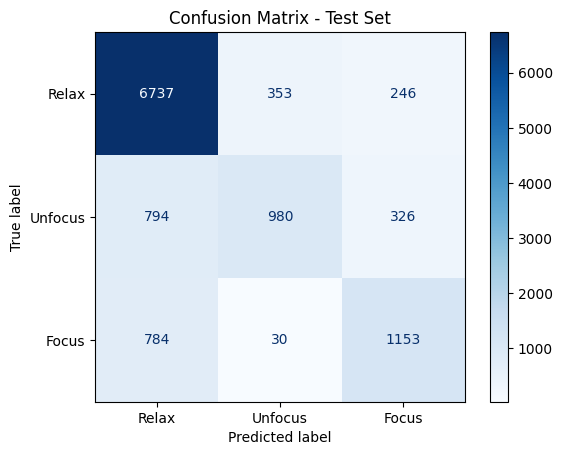

In [4]:
import sklearn
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
from sklearn.model_selection import KFold
from torch.utils.data import Dataset
from collections import Counter
from torch.utils.data import Dataset, DataLoader

segment_len = 64
hop_len = 1 
numClass = 3

ts = '8s'
subject_specs_dicts = np.load(f'Features/features_labels_{ts}_14c.npy', allow_pickle=True).item()

# for ch in subject_specs_dicts:
#     for fname in list_filenames:
#         subject_specs_dicts[ch][fname]['welch'] = subject_specs_dicts[ch][fname]['welch'][:30*60]
#         subject_specs_dicts[ch][fname]['labels'] = subject_specs_dicts[ch][fname]['labels'][:30*60]


num_channels = len(subject_specs_dicts)
list_filenames = list(subject_specs_dicts[0].keys())


class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # shape: (N, channels, time, freq)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def build_dataset(filenames, Hop = 2, channels_idx = None):
    data = []
    labels = []
    for fname in filenames:
        
        if channels_idx == None:
            features = [subject_specs_dicts[ch][fname]['welch'] for ch in range(num_channels)]
        else:
            features = [subject_specs_dicts[ch][fname]['welch'] for ch in channels_idx]
        features = np.concatenate(features, axis=1)  

        label_track = np.asarray(subject_specs_dicts[0][fname]['labels'])
        num_frames = label_track.shape[0]
        

        for i in range(0,num_frames,Hop):
            start = i
            end = start + segment_len

            # Handle last chunk with zero padding
            if end > num_frames:
                pad_len = end - num_frames
                seg_feat = features[start:num_frames, :]
                seg_labels = label_track[start:num_frames]

                # Pad features and labels
                seg_feat = np.pad(seg_feat, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
                seg_labels = np.pad(seg_labels, (0, pad_len), mode='edge')  # repeat last label
            else:
                seg_feat = features[start:end, :]
                seg_labels = label_track[start:end]

            # Majority label
            label_major = Counter(seg_labels).most_common(1)[0][0]

            data.append(seg_feat)
            labels.append(label_major)
            
    data = np.array(data, dtype=np.float32)  # shape: (N, T, F)
    labels = np.array(labels, dtype=np.int64)
    
    if numClass == 2:
        indexes = labels<2
        labels = labels[indexes]
        data = data[indexes]
    

    return data, labels


color_map = {0: 'green', 1: 'orange',2: 'red'}
color_map_pred = {0: 'lightgreen', 1: 'gold', 2: 'salmon'}
label_map_inv =  {0: "Relax", 1: "UnFocus", 2: "Focus"}
label_map = {'Focus': 2, 'Relax': 0, 'Unfocus': 1}
map_indexes = {'AF3':0, 'F7':1, 'F3':2, 'FC5':3, 'T7':4, 'P7':5, 'O1':6, 'O2':7,
    'P8':8, 'T8':9, 'FC6':10, 'F4':11, 'F8':12, 'AF4':13 }

FullChannels = False
if FullChannels==True:
    Plot_Channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
else:
    Plot_Channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8']
    
Channels_idx = [map_indexes[Ch] for Ch in Plot_Channels]

exclude_files = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fs = 128
batch_size = 32
test_state = 0

signal_columns = [col for col in df.columns if col not in ['filename', 'state']]


split_indices = list(kf.split(list_filenames))
train_idx, test_idx = split_indices[test_state]
train_subjects = [list_filenames[i] for i in train_idx if list_filenames[i] not in exclude_files]
test_subjects = [list_filenames[i] for i in test_idx if list_filenames[i] not in exclude_files]

X_train, y_train = build_dataset(train_subjects, channels_idx = Channels_idx)
X_test, y_test = build_dataset(test_subjects, channels_idx = Channels_idx)

train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)
            
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MC_Model_1D(n_channels=num_channels, n_features =X_train.shape[-1]//num_channels, time_steps=segment_len, num_classes=numClass).to(device)    


print(y_train)
counts = np.bincount(y_train)

print(f"N.o 0: {counts[0]}, N.o 1: {counts[1]}, N.o 2: {counts[2]}")



# Load model
model = MC_Model_1D(n_channels=6, n_features=18, time_steps=frame_size, num_classes=3).to(device)
model.load_state_dict(torch.load(f'check_points_8s_{LOSO}/best_model_fold_{test_state}_ind_{Independent}.pt',map_location=torch.device(device)))
model.to(device)
model.eval()

# Predict
with torch.no_grad():
    inputs = torch.from_numpy(X_train).float().to(device)
    outputs = model(inputs)
    y_pred_train = torch.argmax(outputs, dim=1).cpu().numpy()
    accuracy_train = accuracy_score(y_train, y_pred_train)

    inputs = torch.from_numpy(X_test).float().to(device)
    outputs = model(inputs)
    y_pred_test = torch.argmax(outputs, dim=1).cpu().numpy()
    accuracy_test = accuracy_score(y_test, y_pred_test)


print(sklearn.metrics.classification_report(y_test, y_pred_test))



print("\n🧩 Confusion Matrix - Test Set")
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Relax", "Unfocus", "Focus"])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.savefig("images/confusion_matrix_RNN_6c.pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()


# print("*"*40)
# print(sklearn.metrics.classification_report(y_train, y_pred_train))

# print(f"accuracy_train = {accuracy_train} --> accuracy_test = {accuracy_test}")

# print("\n🧩 Confusion Matrix - Train Set")
# cm_train = confusion_matrix(y_train, y_pred_train)
# disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Relax", "Break", "Focus"])
# disp_train.plot(cmap=plt.cm.Greens)
# plt.title("Confusion Matrix - Train Set")
# plt.show()


In [37]:
test_subjects

['eeg_record17.mat',
 'eeg_record23.mat',
 'eeg_record27.mat',
 'eeg_record29.mat',
 'eeg_record31.mat',
 'eeg_record33.mat',
 'eeg_record34.mat']